In [18]:
import yfinance as yf
import pandas as pd
import os

In [19]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [23]:
sp500.index = pd.to_datetime(sp500.index, utc=True)

In [24]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-22 04:00:00+00:00,5319.279785,5323.180176,5286.009766,5307.009766,3847130000,0.0,0.0
2024-05-23 04:00:00+00:00,5340.259766,5341.879883,5256.930176,5267.839844,3869520000,0.0,0.0
2024-05-24 04:00:00+00:00,5281.450195,5311.649902,5278.390137,5304.720215,3005510000,0.0,0.0


<Axes: xlabel='Date'>

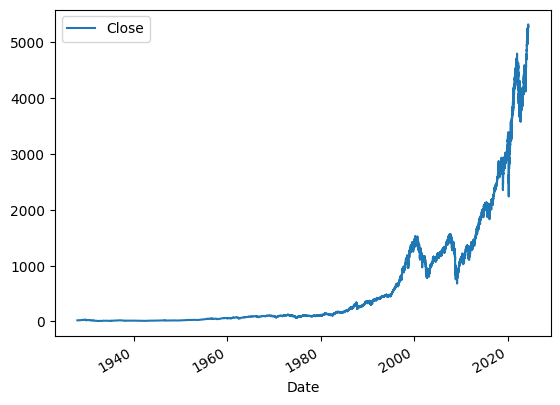

In [25]:
sp500.plot.line(y="Close", use_index=True)

In [26]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [27]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [28]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [29]:
sp500 = sp500.loc["1990-01-01":].copy()

In [30]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [31]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

1.0

<Axes: xlabel='Date'>

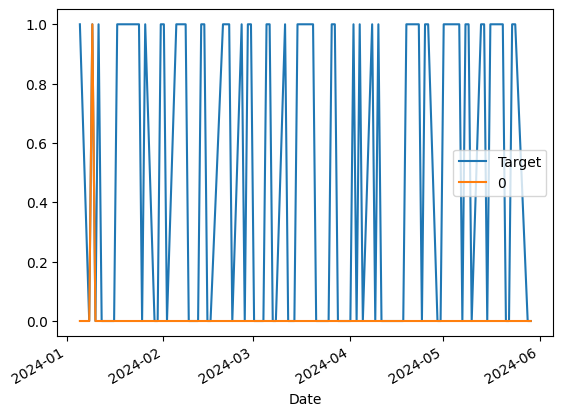

In [32]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [33]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [34]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [35]:
predictions = backtest(sp500, model, predictors)

In [36]:
predictions["Predictions"].value_counts()

Predictions
0    3572
1    2596
Name: count, dtype: int64

In [37]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5288906009244992

In [38]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.534695
0    0.465305
Name: count, dtype: float64

In [39]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [40]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [41]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 05:00:00+00:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 05:00:00+00:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 05:00:00+00:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 05:00:00+00:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 05:00:00+00:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-22 04:00:00+00:00,5319.279785,5323.180176,5286.009766,5307.009766,3847130000,5267.839844,0,0.998645,1.0,0.999929,3.0,1.028594,31.0,1.133315,141.0,1.269859,530.0
2024-05-23 04:00:00+00:00,5340.259766,5341.879883,5256.930176,5267.839844,3869520000,5304.720215,1,0.996296,0.0,0.993645,3.0,1.020349,31.0,1.123878,140.0,1.259840,529.0
2024-05-24 04:00:00+00:00,5281.450195,5311.649902,5278.390137,5304.720215,3005510000,5306.040039,1,1.003488,1.0,1.000547,3.0,1.026802,31.0,1.130686,140.0,1.267995,530.0


In [42]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [43]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [44]:
predictions = backtest(sp500, model, new_predictors)

In [45]:
predictions["Predictions"].value_counts()

Predictions
0.0    4333
1.0     835
Name: count, dtype: int64

In [46]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5736526946107784

In [47]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.544311
0    0.455689
Name: count, dtype: float64

In [48]:
predictions

,Target,Predictions
Date,,
2003-11-14 05:00:00+00:00,0,0.0
2003-11-17 05:00:00+00:00,0,1.0
2003-11-18 05:00:00+00:00,1,1.0
2003-11-19 05:00:00+00:00,0,0.0
2003-11-20 05:00:00+00:00,1,1.0
...,...,...
2024-05-22 04:00:00+00:00,0,0.0
2024-05-23 04:00:00+00:00,1,0.0
2024-05-24 04:00:00+00:00,1,0.0
